<a href="https://colab.research.google.com/github/vitamin1312/MLc/blob/main/Lab2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №2

In [ ]:
!pip install -q catalyst

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.7/446.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.8 MB/s eta 0:00:00


In [ ]:

import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from catalyst import utils

sns.set(style="darkgrid", font_scale=1.4)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn((in_features, out_features)))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn((out_features)))
    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x +=  self.bias
        return x

### Датасет

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

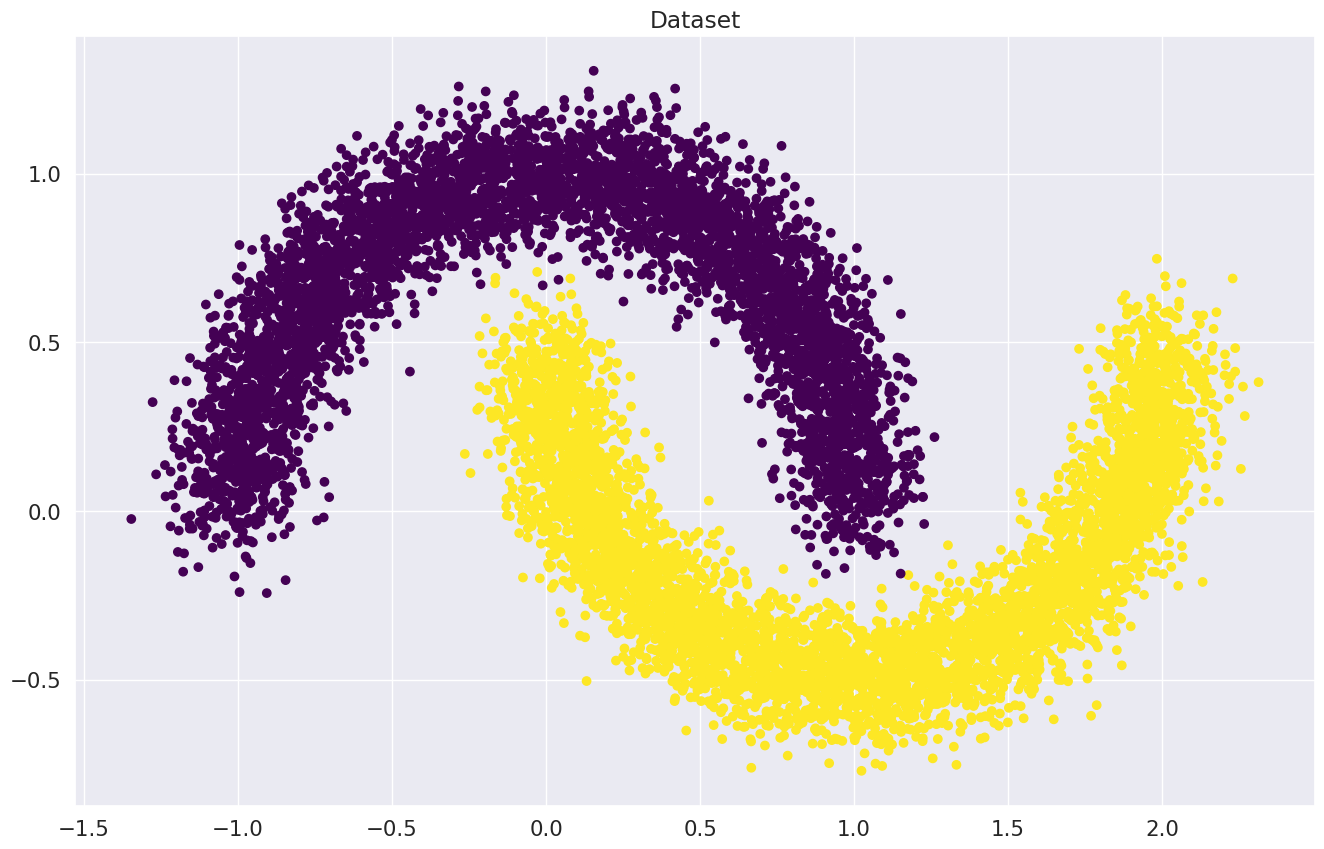

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных

В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.


In [ ]:
X_train_t = torch.tensor(X_train).float()
y_train_t = torch.tensor(y_train).float().view(len(y_train), 1)
X_val_t = torch.tensor(X_val).float()
y_val_t = torch.tensor(y_val).float().view(len(y_val), 1)

Создаем `Dataset` и `DataLoader`.

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [ ]:
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1** Сколько обучаемых параметров у получившейся модели?

**Ответ:** 3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    utils.set_global_seed(42 + epoch)
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss =  loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  outp.sigmoid()
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 62.0
Iteration: 7500
Batch accuracy: 62.0
Iteration: 15000
Batch accuracy: 62.875
Iteration: 22500
Batch accuracy: 63.3125
Iteration: 30000
Batch accuracy: 63.5625
Iteration: 37500
Batch accuracy: 63.59375
Iteration: 45000
Batch accuracy: 63.6875
Iteration: 52500
Batch accuracy: 63.6875
Iteration: 60000
Batch accuracy: 63.71875
Iteration: 67500
Batch accuracy: 63.75
Iteration: 75000
Batch accuracy: 63.78125
Iteration: 82500
Batch accuracy: 63.78125
Iteration: 90000
Batch accuracy: 63.78125
Iteration: 97500
Batch accuracy: 63.78125
Iteration: 105000
Batch accuracy: 63.78125

Iteration: 105047.Convergence. Stopping iterations.


**Вопрос 2**

Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 105047

### Визуализируем результаты

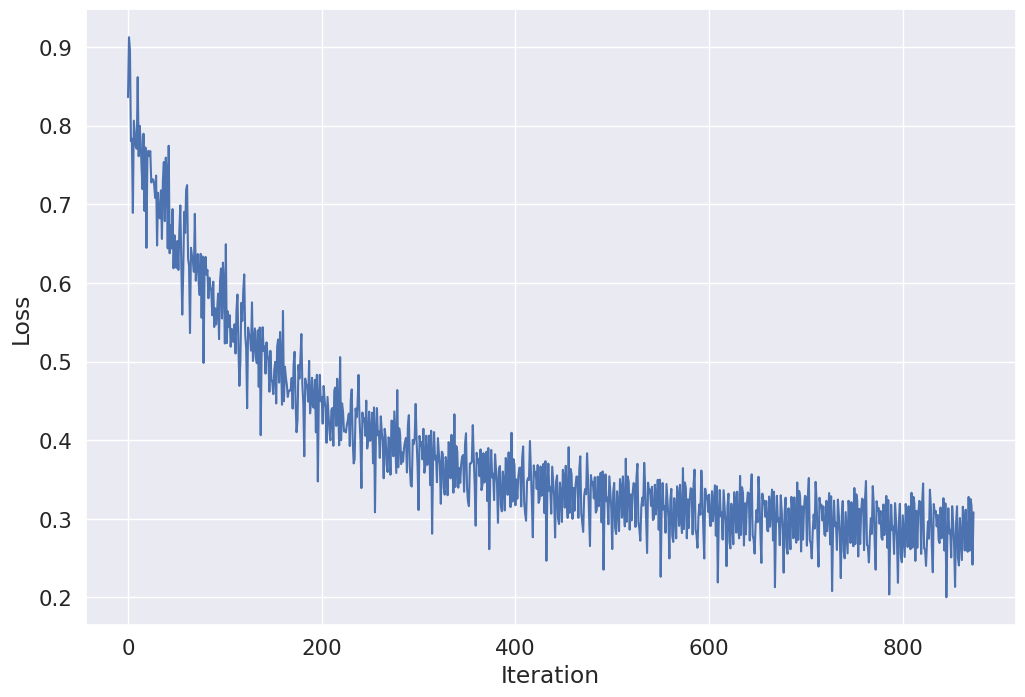

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

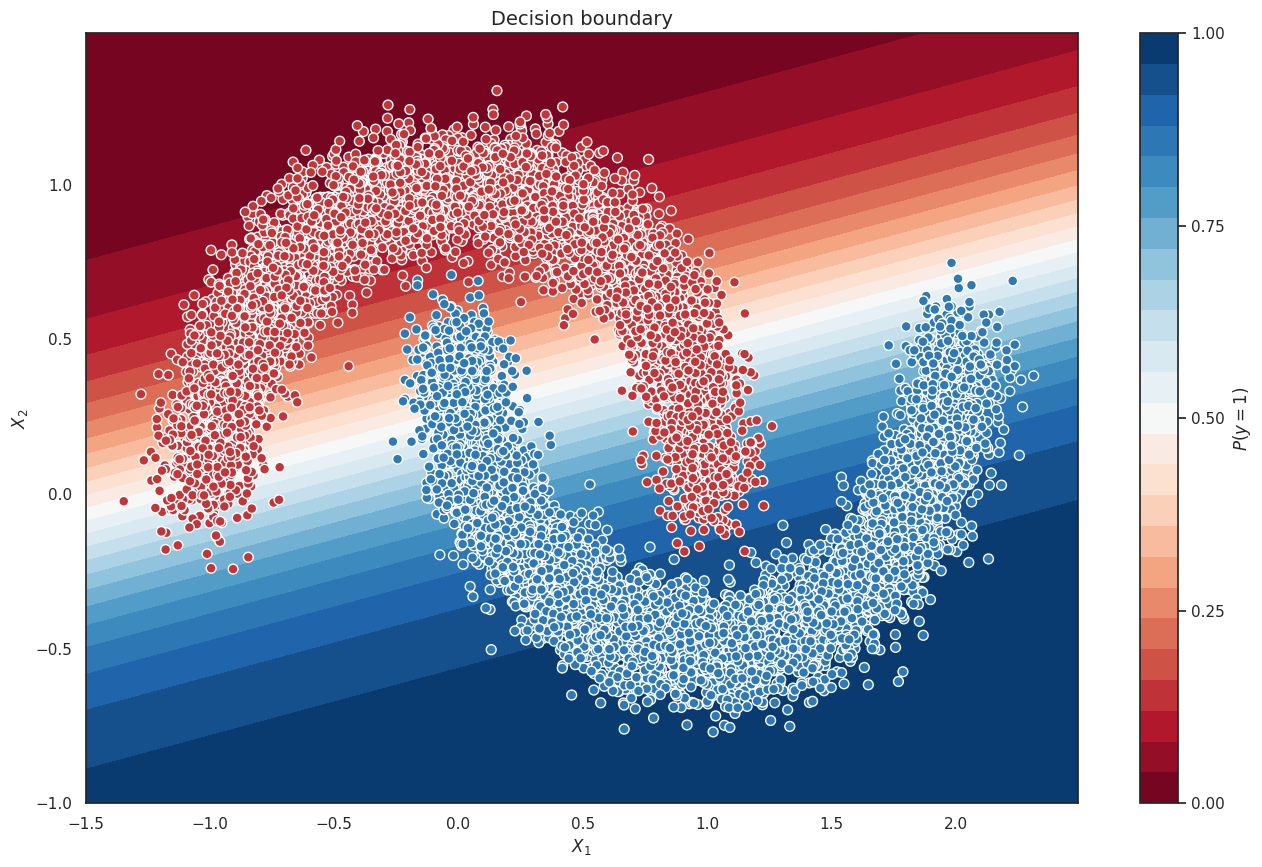

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(predict(val_dataloader, linear_regression), y_val)

0.8856

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8856

### MNIST

In [ ]:
import os
from catalyst.contrib.datasets import MNIST
import torchvision.transforms as transforms
import torchvision.datasets as dsets

BATCH_SIZE = 128

train_data = dsets.MNIST(root='./data', train=True,
                        transform=transforms.ToTensor(), download=True)

valid_data = dsets.MNIST(root='./data', train=False,
                       transform=transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(dataset=valid_data,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False)

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

class COS(nn.Module):
    def forward(self, x):
        return torch.cos(x)

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)

In [ ]:
activation = Identical

model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8858833333333334
Loader: valid. Accuracy: 0.8901857142857142
Epoch: 2
Loader: train. Accuracy: 0.9169666666666667
Loader: valid. Accuracy: 0.9169142857142857
Epoch: 3
Loader: train. Accuracy: 0.9194
Loader: valid. Accuracy: 0.9191142857142857
Epoch: 4
Loader: train. Accuracy: 0.9210166666666667
Loader: valid. Accuracy: 0.9207714285714286
Epoch: 5
Loader: train. Accuracy: 0.9234166666666667
Loader: valid. Accuracy: 0.9232428571428571
Epoch: 6
Loader: train. Accuracy: 0.9251666666666667
Loader: valid. Accuracy: 0.9245428571428571
Epoch: 7
Loader: train. Accuracy: 0.9250666666666667
Loader: valid. Accuracy: 0.9244
Epoch: 8
Loader: train. Accuracy: 0.9256166666666666
Loader: valid. Accuracy: 0.9257
Epoch: 9
Loader: train. Accuracy: 0.9239833333333334
Loader: valid. Accuracy: 0.9237
Epoch: 10
Loader: train. Accuracy: 0.9268833333333333
Loader: valid. Accuracy: 0.9265714285714286


Попробуйте разные функции активации. Позапускайте ячейки сверху несколько раз изменив функции активации. После каждого обучения запустите одну из ячеек снизу. Таким образом мы получим график accuracy/epoch для каждой функции активации.

In [ ]:
plain_accuracy = accuracy["valid"]

In [ ]:
activation = nn.ReLU

model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

relu_accuracy = accuracy["valid"]

Epoch: 1
Loader: train. Accuracy: 0.8894833333333333
Loader: valid. Accuracy: 0.8972571428571429
Epoch: 2
Loader: train. Accuracy: 0.9527333333333333
Loader: valid. Accuracy: 0.9540142857142857
Epoch: 3
Loader: train. Accuracy: 0.9660666666666666
Loader: valid. Accuracy: 0.9663285714285714
Epoch: 4
Loader: train. Accuracy: 0.9741166666666666
Loader: valid. Accuracy: 0.9734857142857143
Epoch: 5
Loader: train. Accuracy: 0.9794833333333334
Loader: valid. Accuracy: 0.9785
Epoch: 6
Loader: train. Accuracy: 0.98375
Loader: valid. Accuracy: 0.9824285714285714
Epoch: 7
Loader: train. Accuracy: 0.9866166666666667
Loader: valid. Accuracy: 0.9851714285714286
Epoch: 8
Loader: train. Accuracy: 0.9886833333333334
Loader: valid. Accuracy: 0.9868285714285714
Epoch: 9
Loader: train. Accuracy: 0.9903166666666666
Loader: valid. Accuracy: 0.9882428571428571
Epoch: 10
Loader: train. Accuracy: 0.99275
Loader: valid. Accuracy: 0.9897285714285714


In [ ]:
activation = nn.LeakyReLU

model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

leaky_relu_accuracy = accuracy["valid"]

Epoch: 1
Loader: train. Accuracy: 0.8898333333333334
Loader: valid. Accuracy: 0.8975
Epoch: 2
Loader: train. Accuracy: 0.9546666666666667
Loader: valid. Accuracy: 0.9557142857142857
Epoch: 3
Loader: train. Accuracy: 0.9676666666666667
Loader: valid. Accuracy: 0.9677571428571429
Epoch: 4
Loader: train. Accuracy: 0.9754
Loader: valid. Accuracy: 0.9747571428571429
Epoch: 5
Loader: train. Accuracy: 0.9802666666666666
Loader: valid. Accuracy: 0.9793428571428572
Epoch: 6
Loader: train. Accuracy: 0.9843833333333334
Loader: valid. Accuracy: 0.9832428571428572
Epoch: 7
Loader: train. Accuracy: 0.9873333333333333
Loader: valid. Accuracy: 0.9858714285714286
Epoch: 8
Loader: train. Accuracy: 0.9891833333333333
Loader: valid. Accuracy: 0.9874285714285714
Epoch: 9
Loader: train. Accuracy: 0.99115
Loader: valid. Accuracy: 0.9888428571428571
Epoch: 10
Loader: train. Accuracy: 0.9927666666666667
Loader: valid. Accuracy: 0.9902428571428571


In [ ]:
activation = nn.ELU

model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

elu_accuracy = accuracy["valid"]

Epoch: 1
Loader: train. Accuracy: 0.8938333333333334
Loader: valid. Accuracy: 0.8996714285714286
Epoch: 2
Loader: train. Accuracy: 0.9485
Loader: valid. Accuracy: 0.9496285714285714
Epoch: 3
Loader: train. Accuracy: 0.9633333333333334
Loader: valid. Accuracy: 0.9635857142857143
Epoch: 4
Loader: train. Accuracy: 0.9723166666666667
Loader: valid. Accuracy: 0.9719428571428571
Epoch: 5
Loader: train. Accuracy: 0.9772166666666666
Loader: valid. Accuracy: 0.9764857142857143
Epoch: 6
Loader: train. Accuracy: 0.9811833333333333
Loader: valid. Accuracy: 0.9803285714285714
Epoch: 7
Loader: train. Accuracy: 0.9844833333333334
Loader: valid. Accuracy: 0.9831714285714286
Epoch: 8
Loader: train. Accuracy: 0.98705
Loader: valid. Accuracy: 0.9855428571428572
Epoch: 9
Loader: train. Accuracy: 0.9892333333333333
Loader: valid. Accuracy: 0.9874285714285714
Epoch: 10
Loader: train. Accuracy: 0.9911666666666666
Loader: valid. Accuracy: 0.9888857142857143


In [ ]:
activation = COS

model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

cos_accuracy = accuracy["valid"]

Epoch: 1
Loader: train. Accuracy: 0.8856
Loader: valid. Accuracy: 0.8962571428571429
Epoch: 2
Loader: train. Accuracy: 0.9699166666666666
Loader: valid. Accuracy: 0.9700285714285715
Epoch: 3
Loader: train. Accuracy: 0.9810166666666666
Loader: valid. Accuracy: 0.9800285714285715
Epoch: 4
Loader: train. Accuracy: 0.9875833333333334
Loader: valid. Accuracy: 0.9853428571428572
Epoch: 5
Loader: train. Accuracy: 0.9912333333333333
Loader: valid. Accuracy: 0.9889571428571429
Epoch: 6
Loader: train. Accuracy: 0.9939166666666667
Loader: valid. Accuracy: 0.9913285714285714
Epoch: 7
Loader: train. Accuracy: 0.9955
Loader: valid. Accuracy: 0.9930285714285715
Epoch: 8
Loader: train. Accuracy: 0.9965833333333334
Loader: valid. Accuracy: 0.9937428571428571
Epoch: 9
Loader: train. Accuracy: 0.9971
Loader: valid. Accuracy: 0.9938857142857143
Epoch: 10
Loader: train. Accuracy: 0.9973166666666666
Loader: valid. Accuracy: 0.9942428571428571


### Accuracy

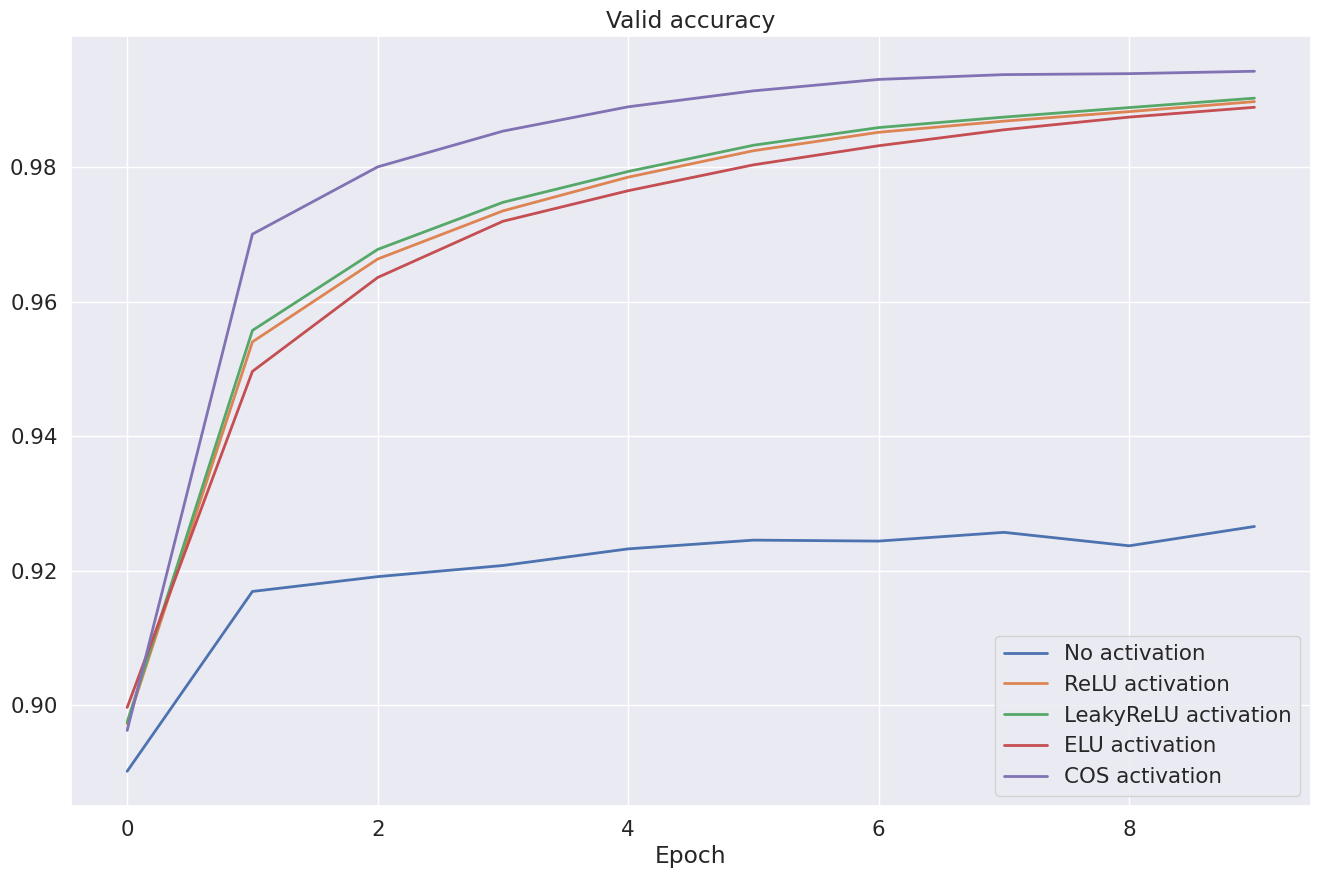

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), cos_accuracy, label="COS activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

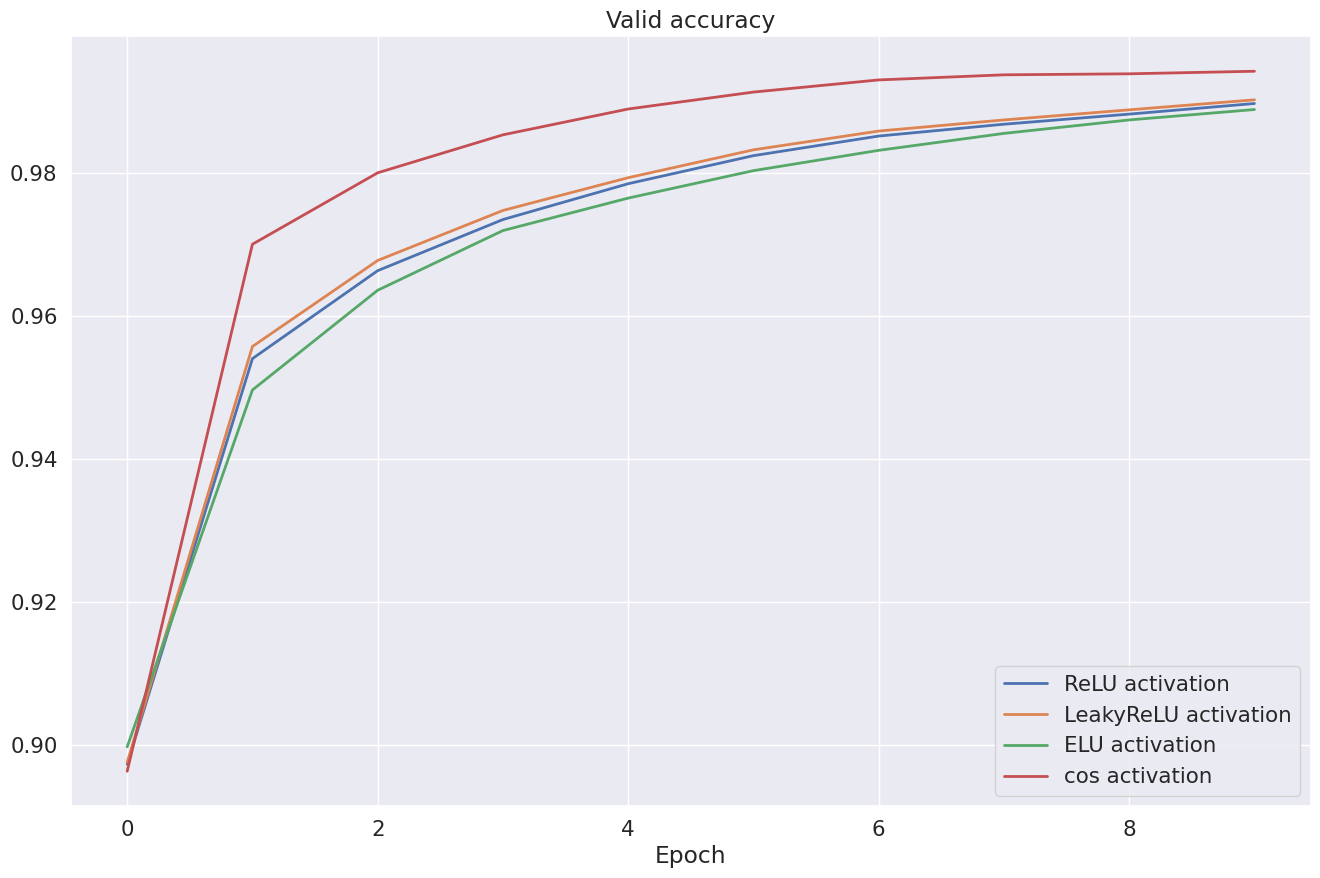

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), cos_accuracy, label="cos activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4** Какая из активаций показала наивысший `accuracy`?

**Ответ:** COS

## Сверточные слои

### Ядра

In [ ]:
# необходимо импортировать свою картинку
# это можно сделать либо с помощью !wget, либо через интерфейс colab'а слева
# в разделе "Files"
!wget https://get.wallhere.com/photo/city-cityscape-building-skyline-skyscraper-evening-HDR-New-York-City-dusk-town-square-Manhattan-metropolis-downtown-plaza-landmark-urban-area-metropolitan-area-human-settlement-214044.jpg -O sample_photo.jpg
# !wget https://gas-kvas.com/uploads/posts/2023-02/1675446360_gas-kvas-com-p-goroda-na-fonovii-risunok-31.jpg -O sample_photo.jpg

--2023-11-23 12:00:18--  https://get.wallhere.com/photo/city-cityscape-building-skyline-skyscraper-evening-HDR-New-York-City-dusk-town-square-Manhattan-metropolis-downtown-plaza-landmark-urban-area-metropolitan-area-human-settlement-214044.jpg
Resolving get.wallhere.com (get.wallhere.com)... 104.26.13.130, 104.26.12.130, 172.67.68.8, ...
Connecting to get.wallhere.com (get.wallhere.com)|104.26.13.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 742346 (725K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>] 724.95K   750KB/s    in 1.0s    

2023-11-23 12:00:20 (750 KB/s) - ‘sample_photo.jpg’ saved [742346/742346]



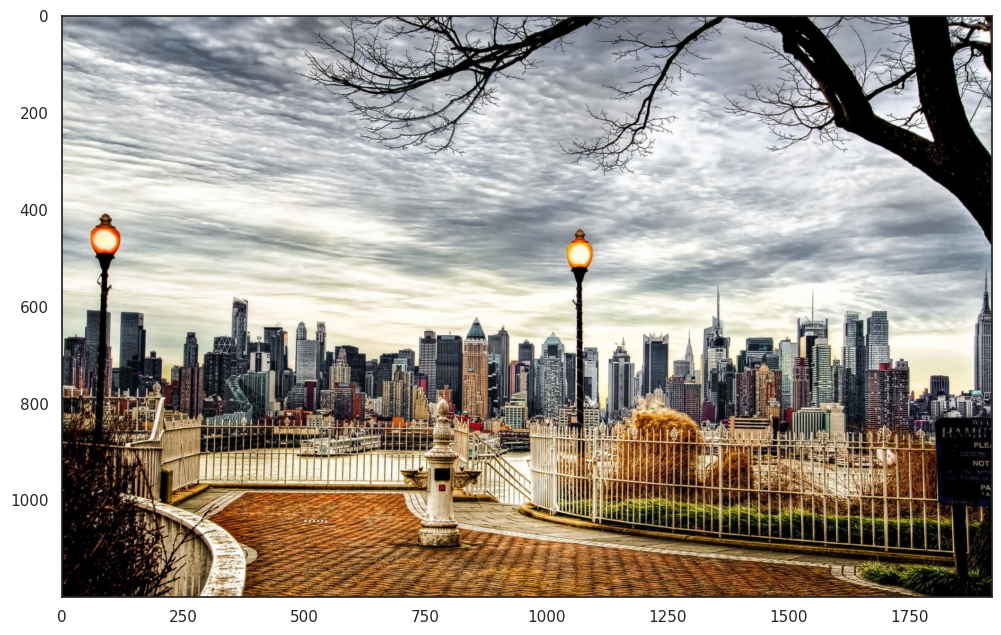

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

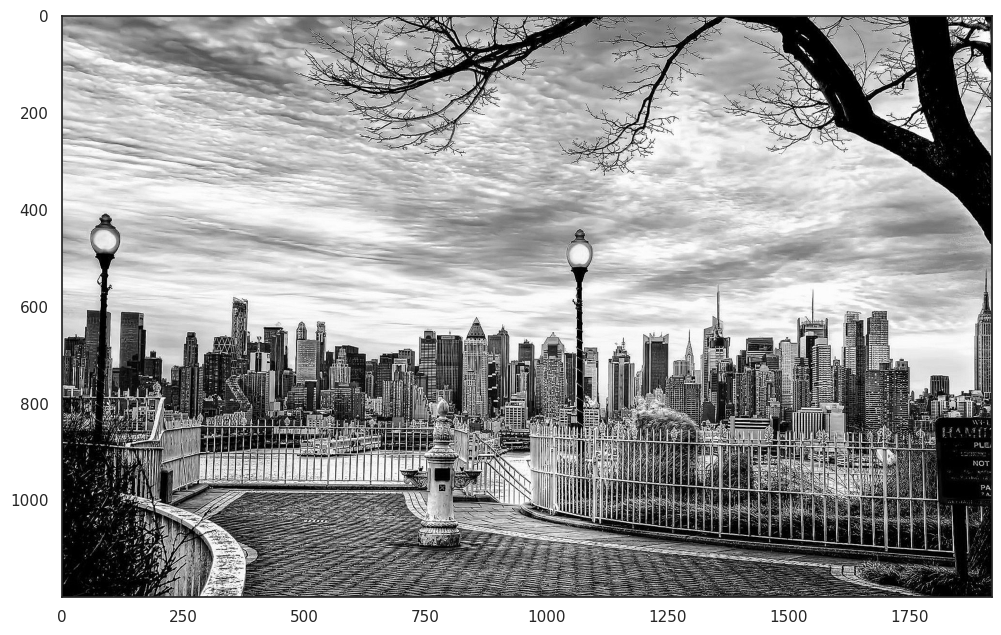

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5** Как вы считаете, как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие Е

2) Увеличение резкости Д

3) Тождественное преобразование А

4) Выделение вертикальных границ И

5) Выделение горизонтальных границ Б

6) Выделение границ Г

**Ответ:**

### LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Давайте посмотрим на архитектуру, предложенную еще в 1998 году!

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                 model.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8356333333333333
Loader: valid. Accuracy: 0.8526142857142858
Epoch: 2
Loader: train. Accuracy: 0.95865
Loader: valid. Accuracy: 0.9604857142857143
Epoch: 3
Loader: train. Accuracy: 0.971
Loader: valid. Accuracy: 0.9722714285714286
Epoch: 4
Loader: train. Accuracy: 0.97865
Loader: valid. Accuracy: 0.9788
Epoch: 5
Loader: train. Accuracy: 0.9829333333333333
Loader: valid. Accuracy: 0.9830571428571429
Epoch: 6
Loader: train. Accuracy: 0.9855166666666667
Loader: valid. Accuracy: 0.9855428571428572
Epoch: 7
Loader: train. Accuracy: 0.9876666666666667
Loader: valid. Accuracy: 0.9876571428571429
Epoch: 8
Loader: train. Accuracy: 0.98825
Loader: valid. Accuracy: 0.9881
Epoch: 9
Loader: train. Accuracy: 0.9897833333333333
Loader: valid. Accuracy: 0.9893857142857143
Epoch: 10
Loader: train. Accuracy: 0.9913833333333333
Loader: valid. Accuracy: 0.9909


In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

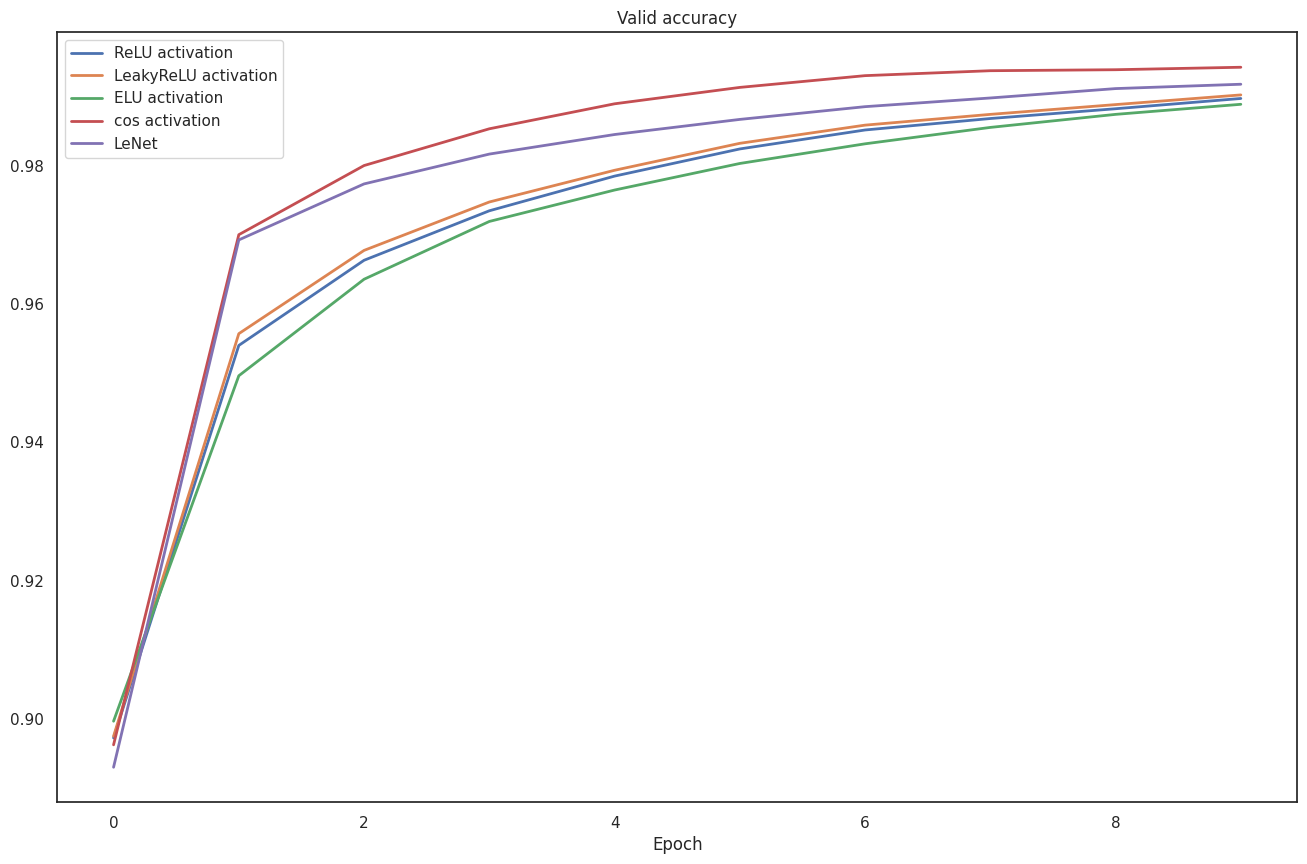

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), cos_accuracy, label="cos activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
import cv2 as cv
from sklearn.cluster import MeanShift
from PIL import Image
from google.colab import files
from io import BytesIO
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision.transforms import v2

In [ ]:
class Learner():

    def __init__(self, model, train_loader, valid_loader,
                 loss_fn, metric, optimizer, classif=True):
        self.model = model
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.loss_fn = loss_fn
        self.metric = metric
        self.optimizer = optimizer
        self.dtype = torch.int64 if classif else torch.float

    def calc_grad(self, xb, yb):
        preds = self.model(xb)
        loss = self.loss_fn(preds, yb)
        loss.backward()
        return loss, preds

    def train_epoch(self):

        epoch_loss = list()
        epoch_metric = list()

        for xb, yb in tqdm(self.train_loader):

            xb = xb.to(device).float()
            yb = yb.to(device).to(self.dtype)

            self.optimizer.zero_grad()
            loss, prds = self.calc_grad(xb, yb)
            self.optimizer.step()

            epoch_loss.append(loss.item())
            epoch_metric.append(self.metric(prds, yb).item())

        return np.round(np.array(epoch_loss).mean(), 6), np.round(np.array(epoch_metric).mean(), 6)


    def validate_epoch(self):

        accuracy = list()
        loss = list()

        with torch.no_grad():
            for xb, yb in tqdm(self.valid_loader):

                xb = xb.to(device).float()
                yb = yb.to(device).to(self.dtype)

                prds = self.model(xb)

                acc = self.metric(prds, yb).item()
                ls = self.loss_fn(prds, yb).item()
                accuracy.append(acc)
                loss.append(ls)

        return np.round(np.array(accuracy).mean(), 6), np.round(np.array(loss).mean(), 6)



    def find_lr(self, init_value, final_value, beta):
        self.model.train(True)
        num = len(self.train_loader)-1
        mult = (final_value / init_value) ** (1/num)
        lr = init_value
        self.optimizer.lr = lr
        avg_loss = 0.
        best_loss = 0.
        batch_num = 0
        losses = []
        log_lrs = []
        for data in tqdm(self.train_loader):

            batch_num += 1

            inputs,labels = data
            inputs, labels = inputs.to(device).float(), labels.to(device).to(self.dtype)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, labels)

            avg_loss = beta * avg_loss + (1-beta) * loss.item()
            smoothed_loss = avg_loss / (1 - beta**batch_num)

            if batch_num > 1 and smoothed_loss > 4 * best_loss:
                return log_lrs, losses

            if smoothed_loss < best_loss or batch_num==1:
                best_loss = smoothed_loss

            losses.append(smoothed_loss)
            log_lrs.append(lr)

            loss.backward()
            self.optimizer.step()

            lr *= mult
            self.optimizer.lr = lr

        return log_lrs, losses


    def plot_lr_finding(self, init_value=1e-8, final_value=1e1, beta = 0.98):
        log_lrs, losses = self.find_lr(init_value, final_value, beta)
        plt.plot(log_lrs, losses)
        plt.grid(True)
        plt.xscale('log')


    def train_model(self, EPOCHS):

        train_loss = list()
        train_metr = list()
        valid_metr = list()
        valid_loss = list()

        for i in range(EPOCHS):

            print(f'epoch: {i+1}/{EPOCHS}')

            print('training model')
            self.model.train(True)
            loss, metr = self.train_epoch()
            train_loss.append(loss)
            train_metr.append(metr)
            print('train_loss: ', loss)
            print('train_metr: ', metr)
            print('validating model')
            self.model.train(False)
            valid_m, valid_ls = self.validate_epoch()
            print('loss: ', valid_ls)
            print('metric: ', valid_m)
            valid_metr.append(valid_m)
            valid_loss.append(valid_ls)

            print()

        return train_metr, train_loss, valid_metr, valid_loss

In [ ]:
class ContextEncoderDset(Dataset):

    def __init__(self, data, start, end, my_transforms=None):
        self.data = data
        self.sl = slice(start, end)
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        x, _ =train_data[idx]
        if my_transforms is not None:
            x = my_transforms(x)

        y = x[:,  self.sl,  self.sl].clone().detach()
        x[:, self.sl,  self.sl] = torch.tensor(0)

        return x, y

In [ ]:
my_transforms = v2.Compose([
    transforms.RandomAffine((-20, 20))
])

In [ ]:
train_dset = ContextEncoderDset(train_data, 8, 20, my_transforms)
valid_dset = ContextEncoderDset(valid_data, 8, 20, my_transforms)

In [ ]:
train_loader = DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
xb, yb = next(iter(valid_loader))
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128, 1, 12, 12]))

In [ ]:
class LeNetEncoder(nn.Module):
    def __init__(self):
        super(LeNetEncoder, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)


    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        return x

In [ ]:
class UpConv(nn.Module):
    def __init__ (self, in_channels, out_channels, kernel_size, padding, stride):
        super(UpConv, self).__init__()
        self.act = nn.ReLU()
        self.conv_trans1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, padding=0, stride=2)
        self.b3 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True)
        self.conv3 = nn.Conv2d(in_channels=out_channels, out_channels= out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        self.b4 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True)
        self.conv4 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        self.b5 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True)


    def forward(self, x):
        x = self.conv_trans1(x)
        x = self.act(self.b3(x))
        x = self.conv3(x)
        x = self.act(self.b4(x))
        x = self.conv4(x)
        x = self.act(self.b5(x))
        return x

In [ ]:
class LeNetDecoder(nn.Module):
    def __init__(self):
        super(LeNetDecoder, self).__init__()
        self.fc1 = nn.Linear(16 * 5 * 5, 576)
        self.conv1 = UpConv(16, 10, 3, 1, 1)
        self.conv2 = nn.Conv2d(10, 1, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = x.view(-1, 16, 6, 6)
        x = F.relu(self.conv1(x))
        x = F.sigmoid(self.conv2(x))
        return x

In [ ]:
class ContextEncoder(nn.Module):
    def __init__(self):
        super(ContextEncoder, self).__init__()
        self.encoder = LeNetEncoder()
        self.decoder = LeNetDecoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
context_model = ContextEncoder().to(device)

learn = Learner(
    context_model,
    train_loader,
    valid_loader,
    torch.nn.MSELoss(),
    torch.nn.L1Loss(),
    torch.optim.Adam(context_model.parameters(), 1e-3),
    classif=False
)

In [ ]:
context_model

ContextEncoder(
  (encoder): LeNetEncoder(
    (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  )
  (decoder): LeNetDecoder(
    (fc1): Linear(in_features=400, out_features=576, bias=True)
    (conv1): UpConv(
      (act): ReLU()
      (conv_trans1): ConvTranspose2d(16, 10, kernel_size=(2, 2), stride=(2, 2))
      (b3): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (b4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (b5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Conv2d(10, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [ ]:
learn.train_model(15)

epoch: 1/15
training model


100%|██████████| 469/469 [01:16<00:00,  6.16it/s]


train_loss:  0.100674
train_metr:  0.24344
validating model


100%|██████████| 79/79 [00:08<00:00,  9.21it/s]


loss:  0.088965
metric:  0.219581

epoch: 2/15
training model


100%|██████████| 469/469 [01:12<00:00,  6.46it/s]


train_loss:  0.081401
train_metr:  0.203792
validating model


100%|██████████| 79/79 [00:10<00:00,  7.74it/s]


loss:  0.078761
metric:  0.192221

epoch: 3/15
training model


100%|██████████| 469/469 [01:13<00:00,  6.42it/s]


train_loss:  0.077393
train_metr:  0.195773
validating model


100%|██████████| 79/79 [00:08<00:00,  9.11it/s]


loss:  0.075777
metric:  0.193345

epoch: 4/15
training model


100%|██████████| 469/469 [01:14<00:00,  6.29it/s]


train_loss:  0.075171
train_metr:  0.191398
validating model


100%|██████████| 79/79 [00:10<00:00,  7.81it/s]


loss:  0.079173
metric:  0.192409

epoch: 5/15
training model


100%|██████████| 469/469 [01:11<00:00,  6.54it/s]


train_loss:  0.073431
train_metr:  0.187879
validating model


100%|██████████| 79/79 [00:08<00:00,  9.06it/s]


loss:  0.078861
metric:  0.19933

epoch: 6/15
training model


100%|██████████| 469/469 [01:08<00:00,  6.81it/s]


train_loss:  0.072507
train_metr:  0.186042
validating model


100%|██████████| 79/79 [00:09<00:00,  8.31it/s]


loss:  0.073412
metric:  0.183372

epoch: 7/15
training model


 26%|██▌       | 121/469 [00:17<00:50,  6.92it/s]


KeyboardInterrupt: ignored

In [ ]:
idx = 13
prds = context_model(xb.to(device))

image = xb[idx][0].numpy() + F.pad(yb[idx][0].detach().cpu(),
                                  pad=(8,8,8,8), value=0).numpy()

result = xb[idx][0].numpy() + F.pad(prds[idx][0].detach().cpu(),
                                  pad=(8,8,8,8), value=0).numpy()
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.imshow(xb[idx][0].numpy(), cmap='gray')
ax2.imshow(image, cmap='gray')
ax3.imshow(result, cmap='gray');

In [ ]:
class LeNet(nn.Module):
    def __init__(self, encoder):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.encoder = encoder
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.encoder(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet(context_model.encoder).to(device)

In [ ]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [ ]:
def batch_accuracy(preds, yb):
    correct = torch.argmax(preds, axis=1) == yb
    return correct.float().mean().cpu()

In [ ]:
learn = Learner(
    model,
    train_dataloader,
    valid_dataloader,
    nn.CrossEntropyLoss(),
    batch_accuracy,
    torch.optim.Adam(model.parameters(), 9e-3),
    classif=True
)

In [ ]:
_, _, acc1, _ = learn.train_model(5)

In [ ]:
for param in model.encoder.parameters():
    param.requires_grad = True

In [ ]:
learn = Learner(
    model,
    train_dataloader,
    valid_dataloader,
    nn.CrossEntropyLoss(),
    batch_accuracy,
    torch.optim.Adam(model.parameters(), 1e-4),
    classif=True
)

In [ ]:
_, _, acc2, _ = learn.train_model(5)

In [ ]:
max_epochs = 10

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), cos_accuracy, label="cos activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.plot(range(max_epochs), acc1 + acc2, label="Self-supervized LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()